# Lecture 07 - Regression

***
##### CS 434 - Dating Mining and Machine Learning
##### Oregon State University-Cascades
***

![alt text](https://i.vas3k.ru/7w5.jpg)

## <img src="https://img.icons8.com/color/32/000000/fork-lift.png"/>  Load packages


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

### <img src="https://img.icons8.com/color/24/000000/cosine.png"/> Helper function for graphing our results

In [0]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

## <img src="https://img.icons8.com/color/32/000000/accept-database.png"/> Prepare a dataset

### <img src="https://img.icons8.com/color/32/000000/database-restore.png"/>  Load the data

Load the Iris dataset from scikit-learn. 

In [0]:
# load Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data= iris.data, columns= iris.feature_names)
target_df = pd.DataFrame(data= iris.target, columns= ['species'])

### <img src="https://img.icons8.com/color/32/000000/search-property.png"/>  Examine the data

The classes are integer labels where 
* 0=Iris-Setosa
* 1=Iris-Versicolor
* 2=Iris-Virginica.

In [0]:
# manually decode to species name
def converter(specie):
    if specie == 0:
        return 'setosa'
    elif specie == 1:
        return 'versicolor'
    else:
        return 'virginica'
target_df['species'] = target_df['species'].apply(converter)

In [0]:
# concatenate the features and labeels
iris_df = pd.concat([iris_df, target_df], axis= 1)
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [0]:
# examine our dataframe
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [0]:
# describe our features
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### <img src="https://img.icons8.com/color/32/000000/split-files.png"/> Split into train and test sets

In this example, 70% is for training and 30% is for testing.

In [0]:
# Converting Objects to Numerical dtype
iris_df.drop('species', axis= 1, inplace= True)
target_df = pd.DataFrame(columns= ['species'], data=iris.target)
iris_df = pd.concat([iris_df, target_df], axis= 1)

# <img src="https://img.icons8.com/color/32/000000/graph.png"/> Visualize the data

In [0]:
# count species
iris_df['species'].value_counts()

2    50
1    50
0    50
Name: species, dtype: int64

In [0]:
# check data shape
rows, col = iris_df.shape
print("Rows : %s, column : %s" % (rows, col))

Rows : 150, column : 5


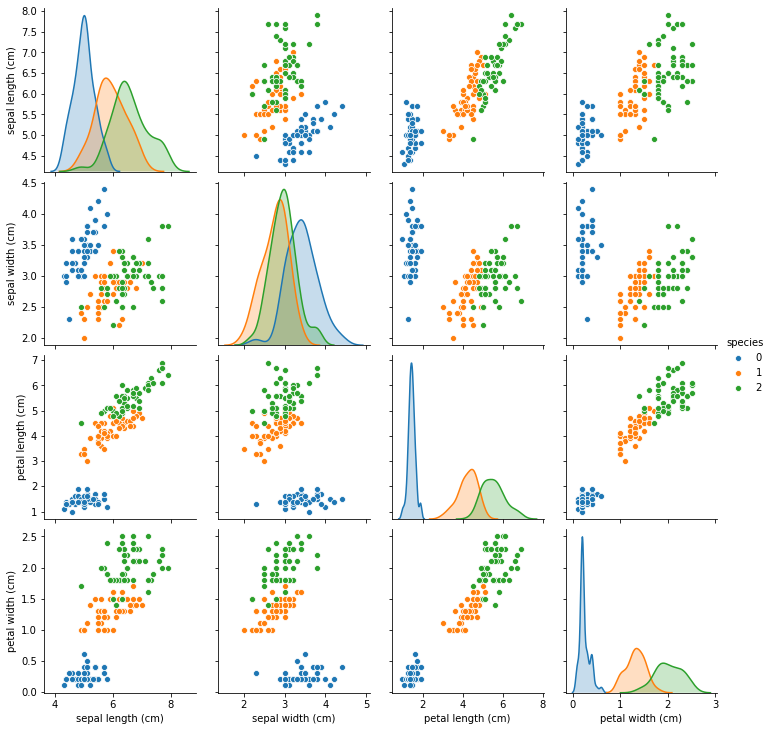

In [0]:
# pairplot features
sns.pairplot(iris_df, hue='species')

In [0]:
# view dataframe
display(iris_df)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


# <img src="https://img.icons8.com/color/32/000000/line.png"/> Simple linear regression

[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) is a linear regression model with a single explanatory variable.

$$y = B_0 + B_1 * x$$
where:
* $y$ is the output variable we want to predict,
* $x$ is the input variable we know, 
* $B_1$ are coefficients that we need to estimate, and
* $B_0$ is the intercept (bias). 

The goal is to find the best estimates for the coefficients to minimize the errors in predicting $y$ from $x$.

We can start off by estimating the value for $B_1$ as:

$$B_1 = {\sum_i(x_i-x_\mu) * (y_i-y_\mu) \over \sum_i(x_i – x_\mu)^2}$$



We can calculate $B_0$ using $B_1$ and some statistics from our dataset.

$$B_0 = y_\mu  – B_1 * x_\mu$$

# <img src="https://img.icons8.com/color/32/000000/scatter-plot.png"/> Linear regression

[Linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) is a linear approach to modeling the relationship between a scalar response (or dependent variable) and one or more explanatory variables (or independent variables).

$$y = B_0 + B_1 * x_1 + B_2 * x_2 +\ldots + B_n * x_n$$

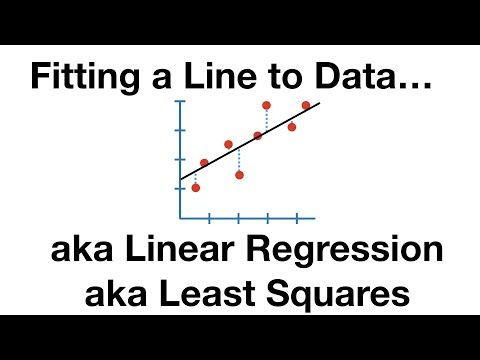

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('PaFPbb66DxQ')

## <img src="https://img.icons8.com/color/32/000000/new-document.png"/> Example

### <img src="https://img.icons8.com/color/32/000000/orchid.png"/> Predict the `sepal length (cm)`.

This is a regression problem, so we need to predict a *continuous* outcome. We choose one of the features.  We treat the class label `species` as just another feature. 

In [0]:
# transform species to integers
le = preprocessing.LabelEncoder()
iris_df['species'] = le.fit_transform(iris_df['species'])

In [0]:
# dependent variable is 'sepal length (cm)'
X = iris_df.drop(labels= 'sepal length (cm)', axis= 1)
y = iris_df['sepal length (cm)']

In [0]:
# split the dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state= 101)

In [0]:
# create a LinearRegression() model
lr = LinearRegression()
lr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# train the model
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# make predictions
lr.predict(X_test)
pred = lr.predict(X_test)

In [0]:
# view predictions
print(pred)

[5.46114587 5.07345452 4.9347765  6.99564965 6.54274665 5.98101314
 5.68344523 5.47200924 5.87249006 4.687635   6.2935498  5.53302753
 4.90789461 7.34015348 6.17439086 6.09386911 6.00159206 6.01550096
 4.73818534 6.6970219  5.49567769 5.21721782 6.03683228 6.24318298
 6.09386911 5.5452921  5.09735047 5.85437218 4.84437129 4.10007944
 6.64781317 5.60092772 6.64459972 5.7094508  6.47068148 6.18614616
 6.42031467 5.96401471 5.88658249 6.82494485 5.10127233 4.76091786
 4.97328977 6.47501437 6.19911914 4.51050332 6.78415406 5.98213258
 4.83046239 4.93319177]


In [0]:
# evaluate model's performance
print('Mean Absolute Error:     %0.4f' % mean_absolute_error(y_test, pred))
print('Mean Squared Error:      %0.4f' % mean_squared_error(y_test, pred))
print('Mean Root Squared Error: %0.4f' % np.sqrt(mean_squared_error(y_test, pred)))

Mean Absolute Error:     0.2596
Mean Squared Error:      0.1017
Mean Root Squared Error: 0.3190


### <img src="https://img.icons8.com/color/32/000000/one-page.png"/> Evaluate a single prediction

In [0]:
# random instance from the data.
row = 6
iris_df.loc[row]

sepal length (cm)    4.6
sepal width (cm)     3.4
petal length (cm)    1.4
petal width (cm)     0.3
species              0.0
Name: 6, dtype: float64

In [0]:
# encode it as a dataframe
d = {'sepal length (cm)' : iris_df.loc[row]['sepal length (cm)'],
    'sepal width (cm)' : iris_df.loc[row]['sepal width (cm)'],
    'petal length (cm)' : iris_df.loc[row]['petal length (cm)'],
    'petal width (cm)' : iris_df.loc[row]['petal width (cm)'],
    'species' : iris_df.loc[row]['species']}
d
test_df = pd.DataFrame(data= d, index=[0])
test_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,4.6,3.4,1.4,0.3,0.0


In [0]:
# predict the 'sepal length (cm)' for the instance. 
x_instance = test_df.drop(labels= 'sepal length (cm)', axis= 1)
print(x_instance)

   sepal width (cm)  petal length (cm)  petal width (cm)  species
0               3.4                1.4               0.3      0.0


In [0]:
# predict instance
pred = lr.predict(x_instance.values)
print('Predicted Sepal Length (cm): %.5f' % pred[0])
print('Actual Sepal Length (cm): %s' % test_df['sepal length (cm)'][0])
print('Error: %.5f' % (abs(test_df['sepal length (cm)'][0] - pred[0])))

Predicted Sepal Length (cm): 4.88750
Actual Sepal Length (cm): 4.6
Error: 0.28750


> For `row=6`, the error is $0.287$ cm, which is a little higher than the MAE.

# <img src="https://img.icons8.com/color/32/000000/spread.png"/> Logistic regression

[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) is a statistical model that in its basic form uses a logistic function to model a binary dependent variable. This allows use of regressive techniques for classification.

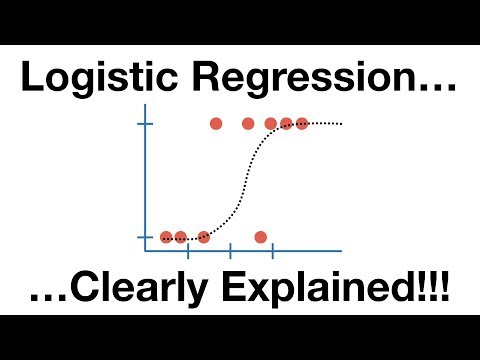

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('yIYKR4sgzI8')

## <img src="https://img.icons8.com/color/32/000000/formula-fx.png"/> Sigmoid function

The sigmoid function takes real-number values as input and transforms them into values in range $[0,1]$ with an intercept at $\phi(z) = 0.5$.

$$\phi(z) = {1 \over {1 + e^{-z}}}$$

where $z$ is a linear combination of weights and feature inputs,

$$z = \mathbf{w^Tx} = w_0 x_0 + w_1 x_1 + \ ... \ + w_m x_m$$

### <img src="https://img.icons8.com/color/32/000000/graph.png"/> Graph of the sigmoid function

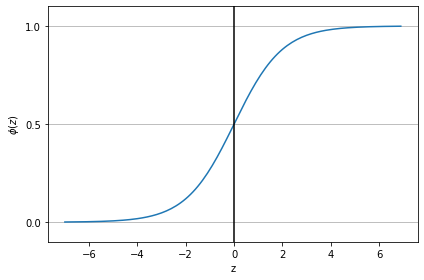

In [0]:
# graph the sigmoid function
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

### <img src="https://img.icons8.com/color/32/000000/weightlift.png"/> Learning the weights of the logistic cost function

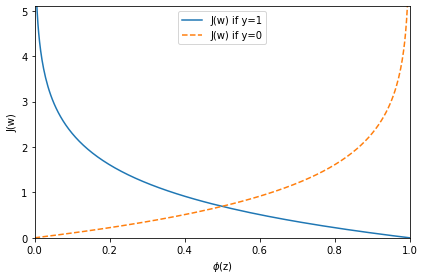

In [0]:
# graph the sigmoid activation
def cost_1(z):
    return - np.log(sigmoid(z))

def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## <img src="https://img.icons8.com/color/32/000000/sort-by-modified-date.png"/> Custom implementation of Logistic Regression

In [0]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Logistic cost function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

### <img src="https://img.icons8.com/color/32/000000/inspect-code.png"/> Examine the decision boundary between two features.

In [0]:
# consider only the third column of the petal length, and 
# the fourth column of petal width of the flower. 
X = iris.data[:, [2, 3]]
y = iris.target

In [0]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

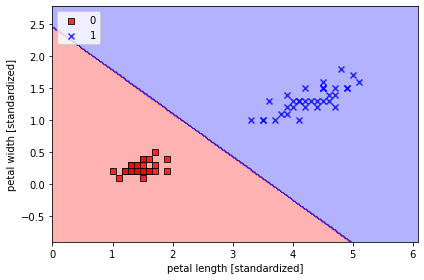

In [0]:
# partition points and plot
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## <img src="https://img.icons8.com/color/32/000000/line-chart.png"/> Logistic Regression with scikit-learn

Load the Iris data again, this time consider the `species` as a classification target. 

In [0]:
# dependent variable is 'species'
X = iris_df.drop(labels= 'species', axis= 1)
y = iris_df['species']

In [0]:
# standardize
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# needed for graphing
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


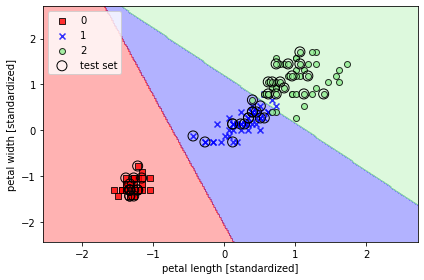

In [0]:
# train model
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

##### Predict new instances

In [0]:
# prediction probabilities
lr.predict_proba(X_test_std[:3, :]) 

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

In [0]:
# verify the class probabilites sum to 1 for each example
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [0]:
# predict the classes, from probabilities
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [0]:
# predict the classes, directly
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

#### Predict a single example

In [0]:
# predict a single example
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])